In [1]:
import pandas as pd
import numpy as np
import warnings
import regex as re
warnings.filterwarnings('ignore')

import pylab as plt
import seaborn as sns

import pickle

In [2]:
data_1 = pd.read_csv('../data/Fraud.csv')

In [3]:
data_1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data_1.shape

(6362620, 11)

In [5]:
data_1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.6 GB


+ step: Indica la unidad de tiempo. En este caso, un paso representa una hora.
+ type: Tipo de transacción (por ejemplo, PAGO, TRANSFERENCIA, RETIRO EN EFECTIVO).
+ amount: Monto de la transacción en moneda local. Aquí tenemos el problema de; no es lo mismo 100€ que 100Yenes, veremos cómo lo afrontamos.
+ nameOrig: Cliente que inició la transacción.
+ oldbalanceOrg: Saldo inicial antes de la transacción.
+ newbalanceOrig: Nuevo saldo después de la transacción.
+ nameDest: Cliente que es el destinatario de la transacción.
+ oldbalanceDest: Saldo inicial del destinatario antes de la transacción. No hay información para clientes que comienzan con M (Comerciantes).
+ newbalanceDest: Nuevo saldo del destinatario después de la transacción. No hay información para clientes que comienzan con M (Comerciantes).
+ isFraud: Indica si la transacción fue fraudulenta o no.
+ isFlaggedFraud: Indica si la transacción fue marcada como fraude debido a un intento de transferencia de más de 200.000 en una sola transacción.

In [6]:
data_1.isna().sum() # confirmamos que no tenemos nulos con los que trabajar

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### Vamos a cambiar nombres de las columnas para visulaizar mejor.

In [7]:
data_1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
data_1 = data_1.rename(columns = {'step':'Time_hour', 'type':'Type', 'amount':'Amount', 'nameOrig':'Origin_ID', 
                                  'oldbalanceOrg':'Old_balance_Org' , 'newbalanceOrig':'New_balance_Org', 
                                  'nameDest':'Destination_ID', 'oldbalanceDest':'Old_balance_Dest', 
                                  'newbalanceDest':'New_balance_Dest', 'isFraud':'Fraud', 
                                  'isFlaggedFraud':'Flagged_Fraud'})

In [9]:
data_1.head()

,Time_hour,Type,Amount,Origin_ID,Old_balance_Org,New_balance_Org,Destination_ID,Old_balance_Dest,New_balance_Dest,Fraud,Flagged_Fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
Time_hour,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
Amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
Old_balance_Org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
New_balance_Org,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
Old_balance_Dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
New_balance_Dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
Fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
Flagged_Fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [11]:
# Vamos a ver los tipo de transacción, por si hacemos algo con ellas.
trans_type = data_1['Type'].value_counts()

# lo que es 1 en cada tipo, en proporción
fraud_proportion = data_1['Fraud'].value_counts(normalize=True) * 100

trans_type, fraud_proportion

(CASH_OUT    2237500
 PAYMENT     2151495
 CASH_IN     1399284
 TRANSFER     532909
 DEBIT         41432
 Name: Type, dtype: int64,
 0    99.870918
 1     0.129082
 Name: Fraud, dtype: float64)

## Análisis descriptivo

+ El step de tiempo va de 1 a 45
+ Solo el 0,0535% de los datos son fraudulentos. Hay un balanceo considerable, para el modelo tendremos que tomar una decisión de si hacer oversampling o undersampling. Ponderación de los datos lo descartamos por ser demasiados datos que ponderar.
+ El montante de las transacciones parece tener cierto equilibrio, así que lo tomaremos como una misma unidad monetaria. Podríamos utilizar el índice PPP (Purchasing Parity Power o PIB per Cápita) para transformar este dato y unificar unidades monetarias, pero al no tener información sobre la moneda tomaremos todas las transacciones como una misma unidad.
+ Las columnas de clientes no parecen tener sentido para nuestro modelo y seguramente las borremos.
+ La columna categórica type podemos aprovecharla, al tener 5 tipos de datos, para transformarlas en variables numéricas 1/0.

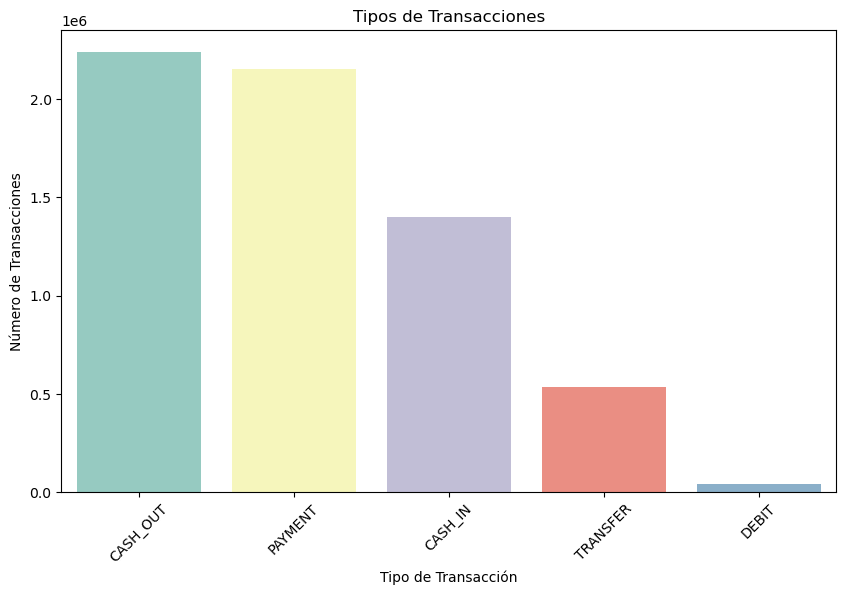

In [12]:
# tipos de transacciones
plt.figure(figsize=(10, 6))
sns.countplot(data=data_1, x="Type", palette="Set3", order=data_1['Type'].value_counts().index)
plt.title("Tipos de Transacciones")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Número de Transacciones")
plt.xticks(rotation=45)
plt.show()

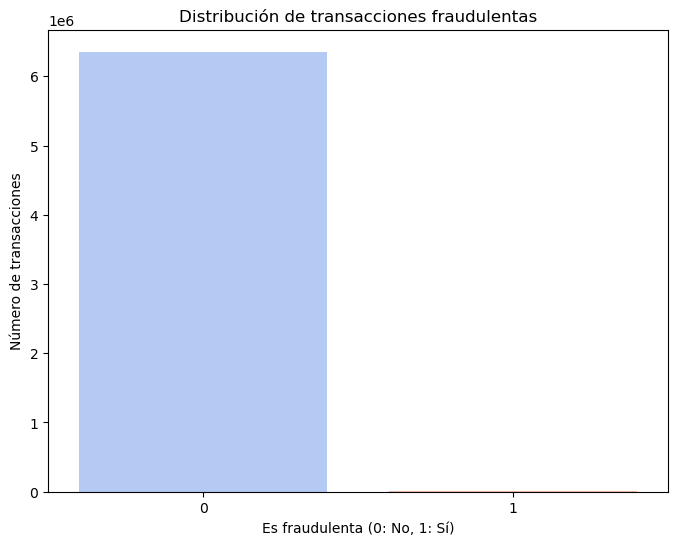

In [13]:
#IsFraud
plt.figure(figsize=(8, 6))
sns.countplot(data=data_1, x='Fraud', palette='coolwarm')
plt.title('Distribución de transacciones fraudulentas')
plt.ylabel('Número de transacciones')
plt.xlabel('Es fraudulenta (0: No, 1: Sí)')
plt.show()

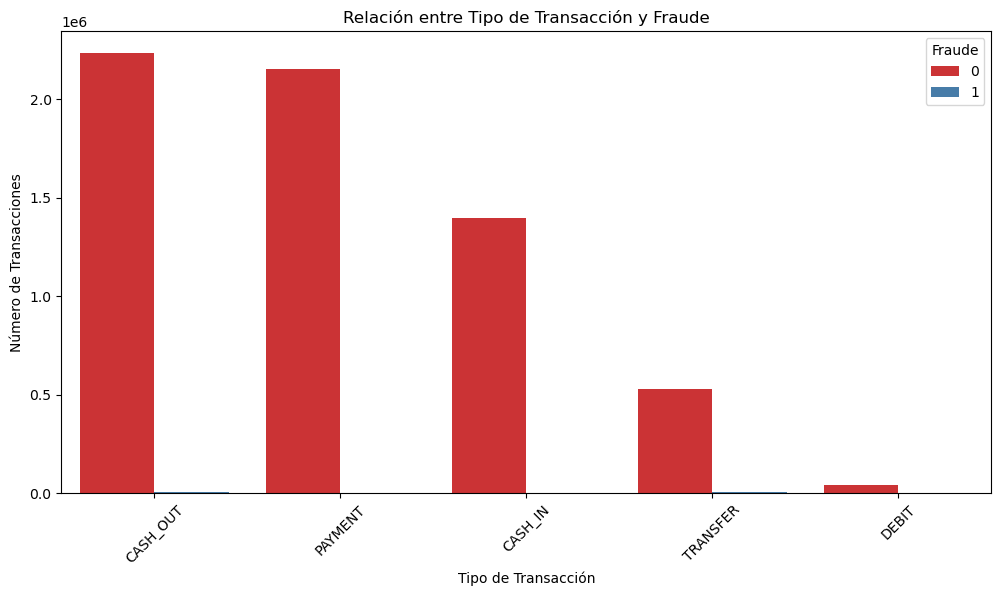

In [14]:
# Vamos a ver la comparación del tipo de transacción y el fraude

plt.figure(figsize=(12, 6))
sns.countplot(data=data_1, x="Type", hue="Fraud", palette="Set1", order=data_1['Type'].value_counts().index)
plt.title("Relación entre Tipo de Transacción y Fraude")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Número de Transacciones")
plt.xticks(rotation=45)
plt.legend(title="Fraude", loc="upper right")
plt.show()

No se ve a simple vista por ser un porcentaje muy pequeño. Tendremos que filtrar más datos. Vamos a filtrar todo lo que sea fraude y ver los tipos a continuación

In [15]:
data_fraud = data_1[data_1['Fraud'] == 1]
data_fraud

,Time_hour,Type,Amount,Origin_ID,Old_balance_Org,New_balance_Org,Destination_ID,Old_balance_Dest,New_balance_Dest,Fraud,Flagged_Fraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


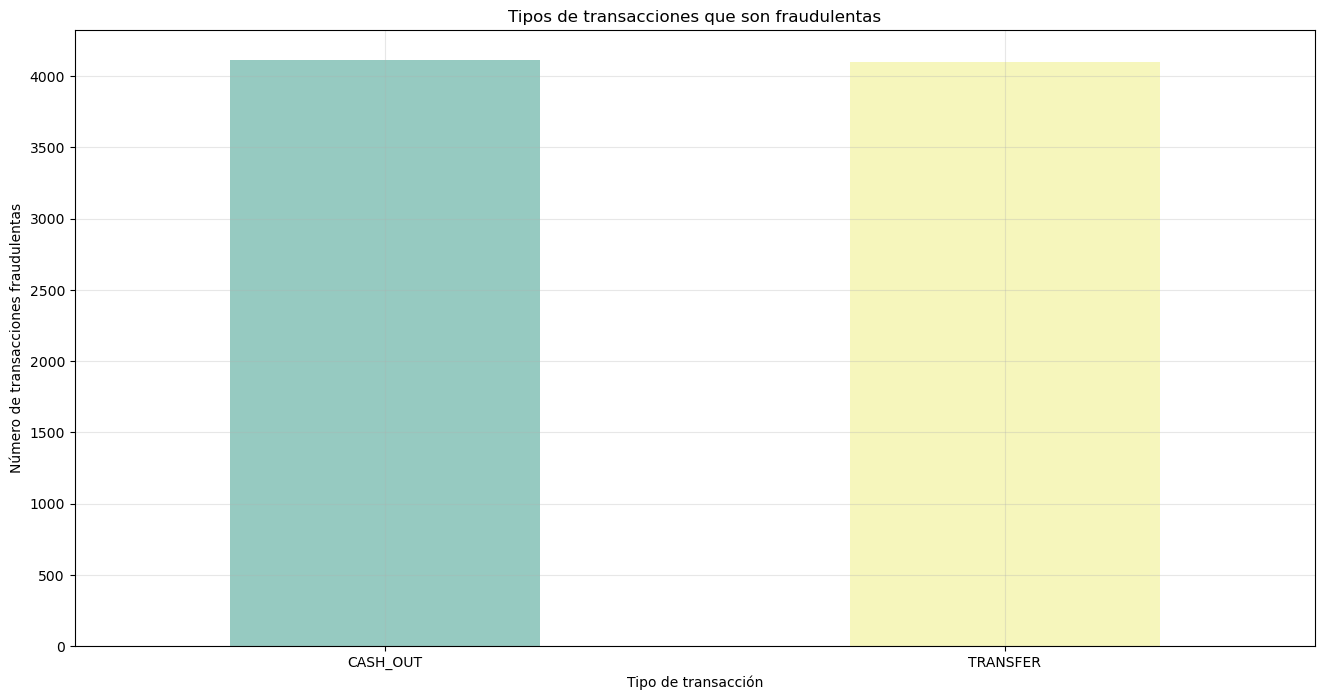

In [16]:
plt.figure(figsize=(16,8))
sns.countplot(data=data_fraud, x='Type', order=data_fraud['Type'].value_counts().index, palette='Set3', width=0.5)
plt.title('Tipos de transacciones que son fraudulentas')
plt.ylabel('Número de transacciones fraudulentas')
plt.xlabel('Tipo de transacción')
plt.grid(alpha=0.3)
plt.show()

## Vamos a ver la relación entre los fraudes y la cantidad de la transacción

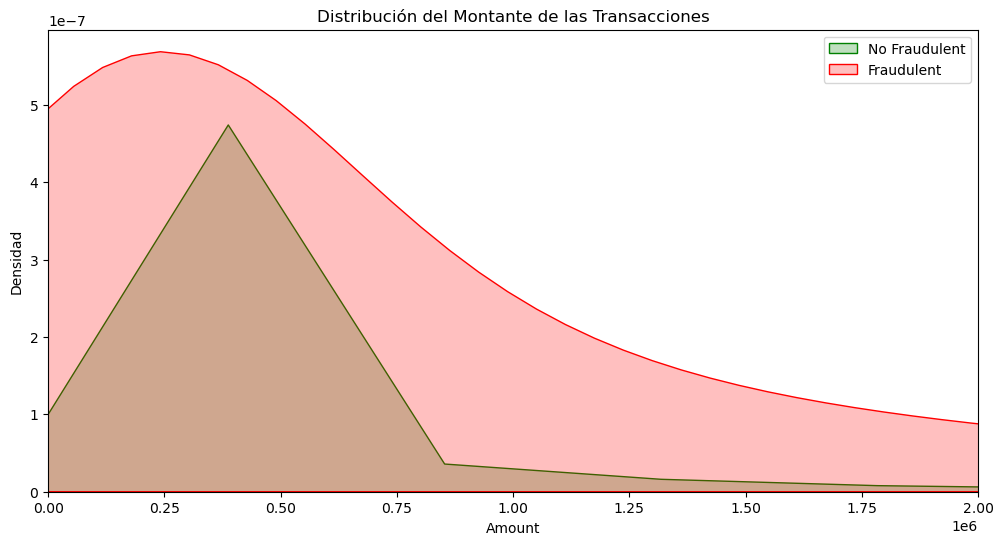

In [17]:
# montante de las transacciones
plt.figure(figsize=(12, 6))
sns.kdeplot(data=data_1[data_1["Fraud"] == 0]["Amount"], label="No Fraudulent", shade=True, color="green")
sns.kdeplot(data=data_1[data_1["Fraud"] == 1]["Amount"], label="Fraudulent", shade=True, color="red")
plt.title("Distribución del Montante de las Transacciones")
plt.xlabel("Amount")
plt.ylabel("Densidad")
plt.legend()
plt.xlim([0, 2e6])  # Limitamos el eje x para verlo desde más cerca
plt.show()

Las transacciones tienen una densidad mayor cerca de 0. Sin embargo, en la fraudulentas vemos como el importe de transacciones es ligeramente mayor que en el resto de transacciones.

In [18]:
data_1['Amount'].value_counts().head(5)

10000000.0    3207
10000.0         88
5000.0          79
15000.0         68
500.0           65
Name: Amount, dtype: int64

In [19]:
data_1.columns

Index(['Time_hour', 'Type', 'Amount', 'Origin_ID', 'Old_balance_Org',
       'New_balance_Org', 'Destination_ID', 'Old_balance_Dest',
       'New_balance_Dest', 'Fraud', 'Flagged_Fraud'],
      dtype='object')

### Vamos a empezar a buscar más patrones concretos para modelar

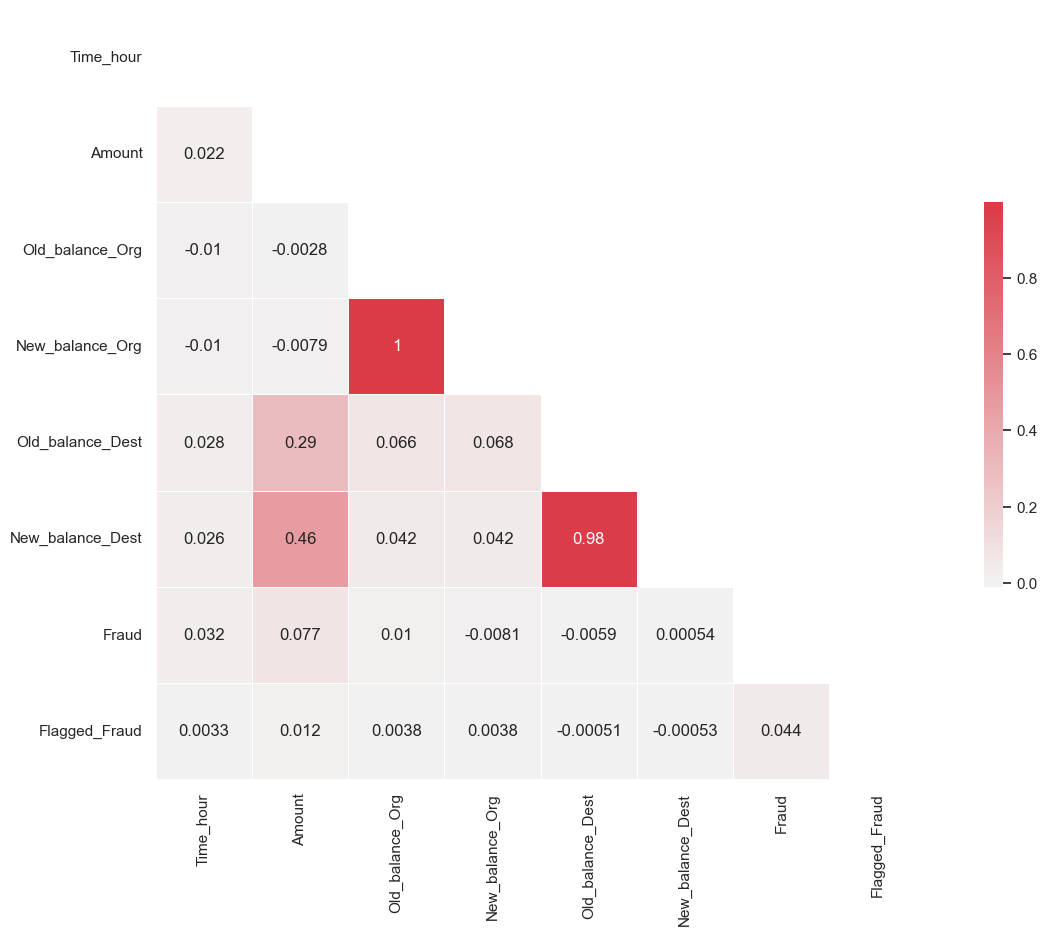

In [20]:
plt.figure(figsize=(15, 10))

sns.set(style='white')

mask=np.triu(np.ones_like(data_1.corr(), dtype=bool))

cmap=sns.diverging_palette(0, 10, as_cmap=True)


sns.heatmap(data_1.corr(),
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

+ Las columnas de balances son las que mayor correlación tienen entre sí, tiene sentido. Para el modelo no lo tiene y valoraremos el eliminar algunas.
+ En nuestra columna objetivo, Fraud, vemos que Amount es la más correlacionada, aunque no tiene un valor alto. Pero al ser positivo nos puede indicar que el fraude aumenta conforme la cantidad de la transacción es mayor.

In [21]:
correlation = data_1.corr()
correlation["Fraud"].sort_values(ascending=False)

Fraud               1.000000
Amount              0.076688
Flagged_Fraud       0.044109
Time_hour           0.031578
Old_balance_Org     0.010154
New_balance_Dest    0.000535
Old_balance_Dest   -0.005885
New_balance_Org    -0.008148
Name: Fraud, dtype: float64

## vamos a ver la distribución de balance de origen y destino

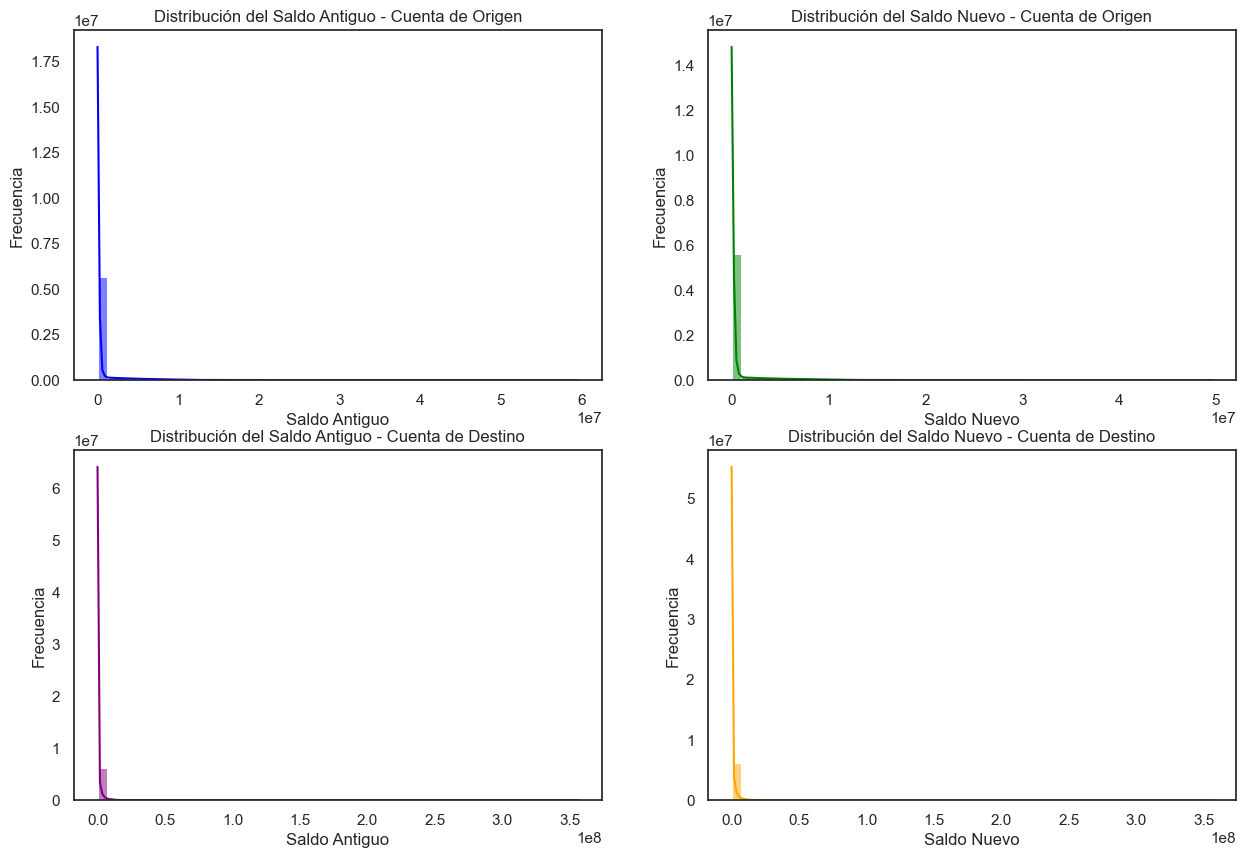

In [22]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data_1["Old_balance_Org"], bins=50, color="blue", kde=True)
plt.title("Distribución del Saldo Antiguo - Cuenta de Origen")
plt.xlabel("Saldo Antiguo")
plt.ylabel("Frecuencia")

plt.subplot(2, 2, 2)
sns.histplot(data_1["New_balance_Org"], bins=50, color="green", kde=True)
plt.title("Distribución del Saldo Nuevo - Cuenta de Origen")
plt.xlabel("Saldo Nuevo")
plt.ylabel("Frecuencia")

plt.subplot(2, 2, 3)
sns.histplot(data_1["Old_balance_Dest"], bins=50, color="purple", kde=True)
plt.title("Distribución del Saldo Antiguo - Cuenta de Destino")
plt.xlabel("Saldo Antiguo")
plt.ylabel("Frecuencia")

plt.subplot(2, 2, 4)
sns.histplot(data_1["New_balance_Dest"], bins=50, color="orange", kde=True)
plt.title("Distribución del Saldo Nuevo - Cuenta de Destino")
plt.xlabel("Saldo Nuevo")
plt.ylabel("Frecuencia")

plt.show()

In [23]:
data_1.head()

,Time_hour,Type,Amount,Origin_ID,Old_balance_Org,New_balance_Org,Destination_ID,Old_balance_Dest,New_balance_Dest,Fraud,Flagged_Fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


No puedo ver mucho en la comparación de balances de arriba. No concuerdan los datos de balances original con los de destino. Parece que dependiendo del tipo de destinatario tenemos más información de su balance. Si el destinatario tiene una categoría de M delante de su ID, no tenemos acceso a su balance inicial y final.

### Vamos con la columna tiempo a ver qué nos dice

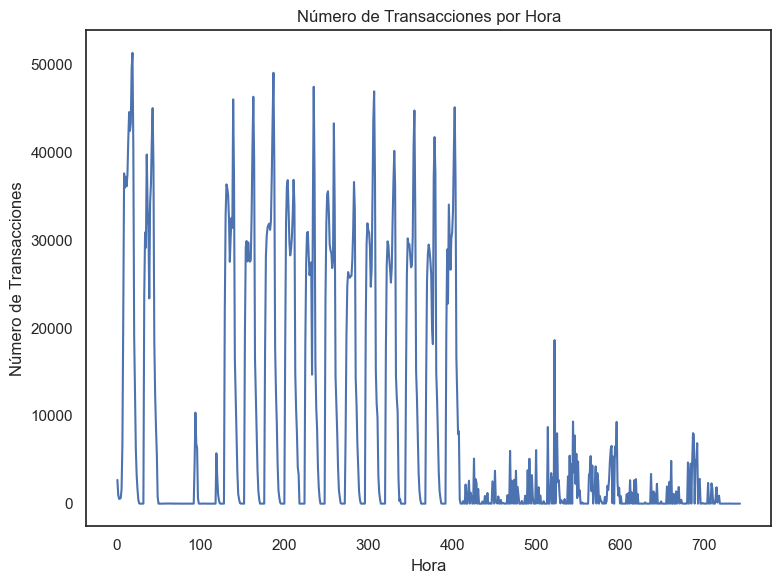

In [24]:
plt.figure(figsize=(15, 6))

# transacciones a lo largo del tiempo
plt.subplot(1, 2, 1)
data_1.groupby('Time_hour').size().plot()
plt.title('Número de Transacciones por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Transacciones')

plt.tight_layout()
plt.show()


Las transacciones tienden a alcanzar su punto máximo durante las primeras horas hasta la hora 50, seguido de una disminución, y luego un aumento nuevamente alrededor de la hora 120 hasta la hora 400. Posteriormente diminuye y se mantiene así hasta su hora máxima.

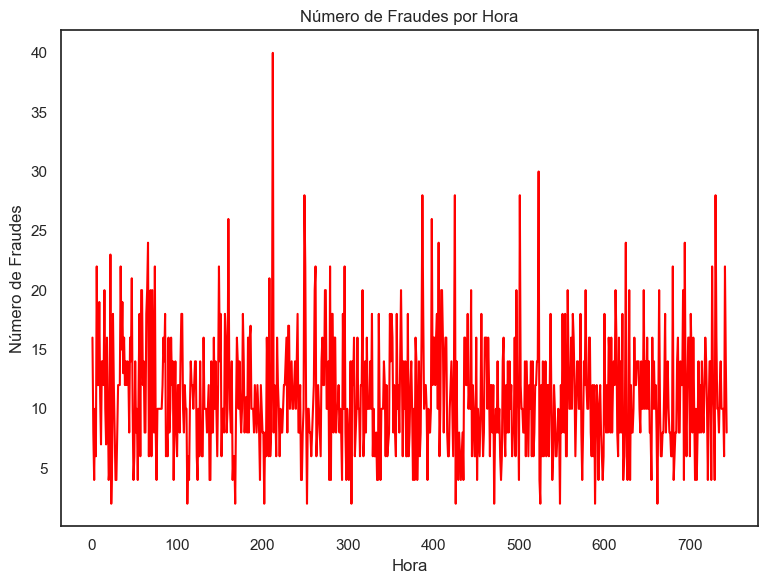

In [25]:
plt.figure(figsize=(15, 6))

# Distribución de fraudes a lo largo del tiempo
plt.subplot(1, 2, 2)
data_1[data_1['Fraud'] == 1].groupby('Time_hour').size().plot(color='red')
plt.title('Número de Fraudes por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Fraudes')

plt.tight_layout()
plt.show()

Esto no tiene sentido. No cumple un patrón de tiempo el fraude.

### Vamos a ver ahora si existen grupos de clientes con tendencia al fraude

In [26]:
# Top cuentas de origen involucradas en fraudes
Origin_ID_fraud = data_1[data_1['Fraud'] == 1]['Origin_ID'].value_counts().head(10)

# Top cuentas de destino involucradas en fraudes
Destination_ID_fraud = data_1[data_1['Fraud'] == 1]['Destination_ID'].value_counts().head(10)

Origin_ID_fraud, Destination_ID_fraud

(C1305486145    1
 C755286039     1
 C973279667     1
 C258213312     1
 C1640703547    1
 C1127265876    1
 C317779855     1
 C1064034527    1
 C1141104763    1
 C1966863341    1
 Name: Origin_ID, dtype: int64,
 C1193568854    2
 C104038589     2
 C200064275     2
 C1497532505    2
 C1601170327    2
 C1655359478    2
 C2020337583    2
 C1653587362    2
 C1013511446    2
 C2129197098    2
 Name: Destination_ID, dtype: int64)

Hay poca reincidencia. Parece que ciertas transacciones realizadas una sola vez fueron 2 veces al mismo destinatario

In [28]:
#EDA terminado
with open('../data/data_eda_total.pkl', 'wb') as det:
    pickle.dump(data_1, det)